In [ ]:
!pip install --force-reinstall 'scikit-learn==0.24.1' 

In [ ]:
!pip install coremltools

In [26]:
import os

import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.svm import SVC
from torch.utils.data import Dataset, DataLoader
import coremltools as cml

In [54]:
# CONST
SEED = 42
DIRECTORY_PATH = '/content/drive/MyDrive/hackAIthon/new_asl'
WINDOW_SIZE = 10
SAVE_WEIGHT = False
LOAD_WEIGHT = False
EPOCHS = 200

In [55]:
random.seed(SEED)
# Numpy
np.random.seed(SEED)
# Pytorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# band-pass filter
def butter_lowpass_filter(x, lowcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    y = signal.filtfilt(b, a, x)
    return y

# ML

## Data


In [56]:
file_paths = [os.path.join(DIRECTORY_PATH, file) for file in os.listdir(DIRECTORY_PATH)]
print(file_paths)

data = []
labels = []
for i in range(len(file_paths)):
    df = pd.read_csv(file_paths[i])
    print('label {}: {}'.format(df.iloc[0]['gesture'], df.shape[0]))
    for j in range(df.shape[0] // WINDOW_SIZE): 
        extracted_ndarray = df.iloc[WINDOW_SIZE*j:WINDOW_SIZE*(j+1), 1:7].to_numpy()
        data.append(np.mean(extracted_ndarray, axis=0)) # preprocess
        labels.append(i)
        # if df.iloc[0]['gesture'] == 'Clench':
        #     labels.append(1)
        # elif df.iloc[0]['gesture'] == 'Pinch':
        #     labels.append(2)
        # elif df.iloc[0]['gesture'] == 'Double Clench':
        #     labels.append(3)
        # elif df.iloc[0]['gesture'] == 'Double Pinch':
        #     labels.append(4)

# TODO: for the test data, apply sliding window

# shuffle
data_labels_combined = list(zip(data, labels))
random.shuffle(data_labels_combined)
data, labels = zip(*data_labels_combined)

# split
train_len = len(data) * 2 // 3
print('train data num: ', train_len)
print('test data num: ', len(data) - train_len)
x_train = data[0:train_len] # len(x_train): data num, x_train[0].shape: (6,) (6 degree of freedom)
y_train = labels[0:train_len] # 'clench': 0, 'pinch': 1, ....
x_test = data[train_len:]
y_test = labels[train_len:]

['/content/drive/MyDrive/hackAIthon/new_asl/face_me_push.csv', '/content/drive/MyDrive/hackAIthon/new_asl/face_right_updown.csv', '/content/drive/MyDrive/hackAIthon/new_asl/face_not_me_updown.csv', '/content/drive/MyDrive/hackAIthon/new_asl/face_up_slice.csv', '/content/drive/MyDrive/hackAIthon/new_asl/face_down_updown.csv']
label Clench: 8342
label Clench: 7534
label Clench: 9036
label Clench: 6639
label Clench: 6905
train data num:  2562
test data num:  1281


In [57]:
df = pd.read_csv(file_paths[0])
df['timestamp'][len(df['timestamp'])-1] - df['timestamp'][0]
df = pd.read_csv(file_paths[1])
df['timestamp'][len(df['timestamp'])-1] - df['timestamp'][0]

152.1323320865631

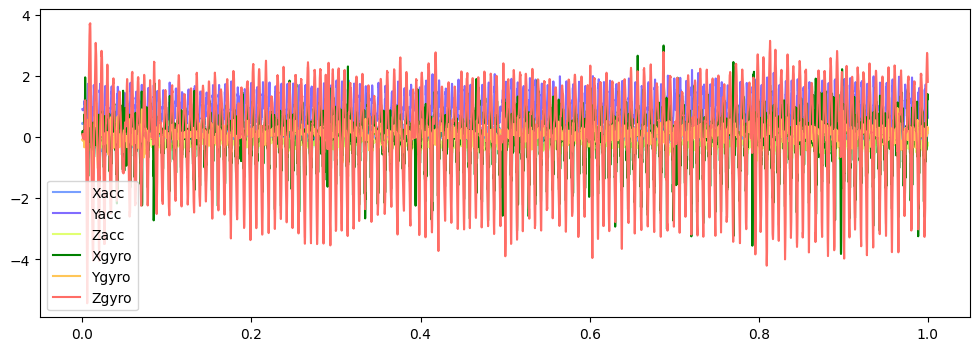

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))

df = pd.read_csv(file_paths[2])
x = np.linspace(0, 1, df.shape[0])
y1 = df.iloc[:, 1]
y2 = df.iloc[:, 2]
y3 = df.iloc[:, 3]
y4 = df.iloc[:, 4]
y5 = df.iloc[:, 5]
y6 = df.iloc[:, 6]
ax.plot(x, y1, color='#789FFF', label='Xacc')
ax.plot(x, y2, color='#816CFF', label='Yacc')
ax.plot(x, y3, color='#E1FF72', label='Zacc')
ax.plot(x, y4, color='green', label='Xgyro')
ax.plot(x, y5, color='#FFC658', label='Ygyro')
ax.plot(x, y6, color='#FF6D66', label='Zgyro')
plt.legend()

plt.show()

## Model

In [59]:
model = SVC(verbose=True, random_state=SEED, probability=True)
model.fit(x_train, y_train)

if SAVE_WEIGHT:
    with open(os.path.join(DIRECTORY_PATH, 'SVM.pickle'), mode='wb') as f:
        pickle.dump(model, f)

[LibSVM]

In [60]:
if LOAD_WEIGHT:
    with open(os.path.join(DIRECTORY_PATH, 'SVM.pickle'), mode='rb') as f:
        model = pickle.load(f)
        
pred = model.predict(x_test)

In [61]:
num_correct = sum(1 for pred, corr in zip(pred, y_test) if pred == corr)
print(num_correct / len(x_test))

0.9547228727556596


In [50]:
# TODO: write output for Kai
print(model.predict_proba(x_test))

[[9.96747780e-01 1.19626616e-03 5.68103468e-04 5.27723602e-04
  9.60126846e-04]
 [1.51212517e-04 5.65168035e-01 4.33524463e-01 1.12523837e-03
  3.10507091e-05]
 [3.53445812e-04 7.41763026e-02 9.24618210e-01 5.52080671e-04
  2.99961017e-04]
 ...
 [9.95699662e-01 2.19399323e-03 7.09339400e-04 4.01873897e-04
  9.95131074e-04]
 [9.95577412e-01 1.82718655e-03 6.59410193e-04 5.66037762e-04
  1.36995335e-03]
 [6.38202861e-05 2.28521137e-03 1.07535348e-03 9.95965720e-01
  6.09894680e-04]]


In [62]:
# output model for ios
swift_model = cml.converters.sklearn.convert(
    model
)

swift_model.save('/content/drive/MyDrive/hackAIthon/SVM.mlmodel')

# DL

## Data

In [ ]:
file_paths = [os.path.join(DIRECTORY_PATH, file) for file in os.listdir(DIRECTORY_PATH)]

data = []
labels = []
for i in range(len(file_paths)):
    df = pd.read_csv(file_paths[i])
    for j in range(df.shape[0] // WINDOW_SIZE): 
        extracted_ndarray = df.iloc[WINDOW_SIZE*j:WINDOW_SIZE*(j+1), 1:7].to_numpy()
        # wave analysis
        transposed_ndarray = np.transpose(extracted_ndarray)
        wave_analyzed_ndarray = []
        for k in range(transposed_ndarray.shape[0]):
            temp_wave_analyzed = []
            temp_wave_analyzed.append(transposed_ndarray[k]) 
            temp_wave_analyzed.append(transposed_ndarray[k]) # TODO: lowpass
            temp_wave_analyzed.append(transposed_ndarray[k]) # TODO: middlepass
            temp_wave_analyzed.append(transposed_ndarray[k]) # TODO: highpass
            wave_analyzed_ndarray.append(temp_wave_analyzed)            
        data.append(np.transpose(np.array(wave_analyzed_ndarray), axes=(1,0,2))) # Making (6, 4, 10) to (4, 6, 10) for the sake of MBConv
        labels.append(i) 

# shuffle
data_labels_combined = list(zip(data, labels))
random.shuffle(data_labels_combined)
data, labels = zip(*data_labels_combined)

# split
train_len = len(data) * 2 // 3

x_train = data[0:train_len] # len(x_train): datanum, x_train[0].shape: (10, 6)
y_train = labels[0:train_len]
x_test = data[train_len:]
y_test = labels[train_len:]

In [ ]:
# Dataset
class CustomData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

train_dataset = CustomData(x_train, y_train)
test_dataset = CustomData(x_test, y_test)

In [ ]:
# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model

In [ ]:
class MBConv1(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MBConv1, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
        self.batch_norm1 = nn.BatchNorm2d(num_features=in_channels)
        self.swish = nn.SiLU()
        # TODO: SE
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.batch_norm2 = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.batch_norm1(x)
        x = self.swish(x)
        x = self.conv(x) 
        x = self.batch_norm2(x)
        return x


class MBConv6(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MBConv6, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*6, kernel_size=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=in_channels*6)
        self.swish = nn.SiLU()
        self.depthwise_conv = nn.Conv2d(in_channels=in_channels*6, out_channels=in_channels*6, kernel_size=kernel_size)
        self.batch_norm2 = nn.BatchNorm2d(num_features=in_channels*6)
        # TODO: SE
        self.conv2 = nn.Conv2d(in_channels=in_channels*6, out_channels=out_channels, kernel_size=1)
        self.batch_norm3 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.swish(x)
        x = self.depthwise_conv(x)
        x = self.batch_norm2(x)
        # TODO: SE
        x = self.swish(x)
        x = self.conv2(x)
        x = self.batch_norm3(x)

        return x

In [ ]:
class AppleASLDecoder(nn.Module): 
    def __init__(self, num_classes):
        super(AppleASLDecoder, self).__init__()
        # TODO: detrend
        self.mbconv1 = MBConv1(4, 16, (1, 2)) # In the paper, (1,10)
        self.mbconv6 = MBConv6(16, 24, (1, 2)) # In the paper, (1, 10)
        self.separableconv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1, 2)) # In the paper (1, 10)
        # TODO: Maxpool
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(1008, 80)
        self.dense2 = nn.Linear(80, 40)
        self.dense3 = nn.Linear(40, 20)
        self.dense4 = nn.Linear(20, 10)
        self.dense5 = nn.Linear(10, num_classes)

    def forward(self, x):
        x = self.mbconv1(x)
        x = self.mbconv6(x)
        x = x.view(x.shape[0], x.shape[1]*x.shape[2], x.shape[3])
        x = torch.unsqueeze(x, 1)
        x = self.separableconv(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)

        return x

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, 2)  # input channels: 6, output channels: 32, kernel size: 2x2
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)  # max pooling with kernel size 2x2        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 1 * 4, 2)  # fully connected layer with 2 output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
model = AppleASLDecoder(2)
# model = SimpleCNN()

## Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_acc_list = []
train_loss_list = []
valid_acc_list = []
valid_loss_list = []

for epoch in range(EPOCHS):
    model.train()
    train_acc = 0
    train_loss_epoch = 0
    for batch_data, batch_labels in train_dataloader: 
        optimizer.zero_grad()
        batch_data = batch_data.type(torch.FloatTensor).to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_data)
        train_loss = criterion(outputs, batch_labels)
        train_loss_epoch += train_loss.item()
        for i in range(len(batch_labels)):
            if torch.argmax(outputs[i]) == torch.argmax(batch_labels[i]):
                train_acc += 1
        train_loss.backward()
        optimizer.step()

    train_acc_list.append(train_acc / len(train_dataset)) 
    train_loss_list.append(train_loss_epoch / len(train_dataset))

    # valid
    model.eval()
    valid_acc = 0
    valid_loss_epoch = 0
    with torch.no_grad():
        for batch_data, batch_labels in test_dataloader:
            batch_data = batch_data.type(torch.FloatTensor).to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data)
            valid_loss = criterion(outputs, batch_labels)
            valid_loss_epoch += valid_loss.item()
            for i in range(len(batch_labels)):
                if torch.argmax(outputs[i]) == torch.argmax(batch_labels[i]):
                    valid_acc += 1

        # TODO: if valid acc exceeds valid_acc_max, save the weight

        valid_acc_list.append(valid_acc / len(test_dataset))
        valid_loss_list.append(valid_loss_epoch / len(test_dataset))

In [ ]:
print(train_acc_list)
print(valid_acc_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01282051282051282, 0.038461538461538464, 0.358974358974359, 0.8461538461538461, 0.9487179487179487, 0.9743589743589743, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9871794871794872, 0.9743589743589743, 0.9615384615384616, 0.9230769230769231, 0.8974358974358975, 0.8974358974358975, 0.8717948717948718, 0.8589743589743589, 0.8461538461538461, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205128205, 0.8205128205